<a href="https://colab.research.google.com/github/hasibzunair/neuralwhat/blob/master/colabs/experimental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import pandas as pd 
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt

from imgaug import augmenters as iaa
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K

np.random.seed(1)

In [38]:
!pip install imgaug

In [3]:
!ls

sample_data


In [0]:
# standard augment 
seq1 = iaa.Sequential([
    iaa.Crop(px=(0, 16)), 
    iaa.Fliplr(0.5), 
    iaa.GaussianBlur(sigma=(0, 3.0))
])

# new augment
seq2 = iaa.Sequential([
    iaa.ContrastNormalization((0.5, 1.5)),
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.Sometimes(0.7, 
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)
    ),
    iaa.Affine(
        rotate=(-25, 25),
    ),
    iaa.Affine(
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
    ),
    iaa.Affine(
        shear=(-25, 25)
    ),
    
    #iaa.Sometimes(0.8, 
     #   iaa.CoarseDropout(0.03, size_percent=0.1)
    #),
], random_order=True) # apply augmenters in random order


# data augmentation
def augment_data_minimal( x_values, y_values ):
    counter = 0
    RESIZE_DIM = 96
    X_values_augmented = []
    Y_values_augmented = []
    for x in x_values:
        for p in range(2):
            
            # seq 1
            Y_values_augmented.append( y_values[counter] )
            images_aug = seq_standard.augment_images(x.reshape(1,RESIZE_DIM,RESIZE_DIM,3))   
            X_values_augmented.append( images_aug.reshape(RESIZE_DIM,RESIZE_DIM,3))
            
            # seq 2
            Y_values_augmented.append( y_values[counter] )
            images_aug = seq_custom.augment_images(x.reshape(1,RESIZE_DIM,RESIZE_DIM,3))   
            X_values_augmented.append( images_aug.reshape(RESIZE_DIM,RESIZE_DIM,3))

        counter = counter + 1
    
    
    # prev number of images = n
    # augmented number of images = n * 4 ( 2 seq 2 times)
    X_values_augmented = np.asarray( X_values_augmented )
    Y_values_augmented = np.asarray( Y_values_augmented )
    return (X_values_augmented, Y_values_augmented)
  
  
  # test time augmentation
def test_of_time(x_test):
  '''
  Arg: x_test: number of test samples of shape (N, w,h,3)
  Returns the predicted labels using test time augmentation    
  '''
  pred_label = []
  label = []
  # number of samples in test set
  l = len(x_test)
  for i in range(l):
      # normal sample
      img = x_test[i]
      # augmented sample reshaped(seq acceptd rank-4 tensor) and fed to sequences
      img_a = seq1.augment_images(img.reshape(1,RESIZE_DIM,RESIZE_DIM,3))
      img_b = seq2.augment_images(img.reshape(1,RESIZE_DIM,RESIZE_DIM,3))
      #img_c = seq3.augment_images(img.reshape(1,RESIZE_DIM,RESIZE_DIM,3))

      # augmented sample reshaped back in normal(rank-3 tensor)
      img_a_out = img_a.reshape(RESIZE_DIM,RESIZE_DIM,3)
      img_b_out = img_b.reshape(RESIZE_DIM,RESIZE_DIM,3)
      #img_c_out = img_c.reshape(RESIZE_DIM,RESIZE_DIM,3)

      # test of time!
      y_test1 = model.predict(img_a_out[None,:,:,:])
      y_test2 = model.predict(img_b_out[None,:,:,:])
      #y_test3 = model.predict(img_c_out[None,:,:,:])
      y_test3 = model.predict(img[None,:,:,:])

      # change the params in the weighted average equation for minor changes in the performance
      # future works: arithmetic mean

      # coefficients should add up to 1!
      #y_test = .2*y_test1 + .2*y_test2 + .2*y_test3 + .4*y_test4
      y_test = .2*y_test1 + .2*y_test2 + .6*y_test3
      label.append(y_test)

  # convert to final predicted labels
  pred_labels=np.concatenate(label)
  return pred_labels


In [4]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
!nvidia-smi

Wed Jan 23 15:36:26 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    56W / 149W |    116MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [7]:
!ls

sample_data


In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [9]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [10]:
!ls

kaggle.json  sample_data


In [0]:
!cp kaggle.json ~/.kaggle/

In [12]:
#!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!kaggle datasets download -d hasibzunair/malaria

 99% 809M/815M [00:17<00:00, 21.8MB/s]
100% 815M/815M [00:17<00:00, 49.3MB/s]


In [13]:
!ls

kaggle.json  malaria.zip  sample_data


In [0]:
os.listdir()

['.config', 'kaggle.json', 'malaria.zip', 'sample_data']

In [14]:
!unzip 'malaria.zip'

Archive:  malaria.zip
  inflating: y_test.npy              
  inflating: x_test.npy              
  inflating: y_train.npy             
  inflating: y_val.npy               
  inflating: x_train.npy             
  inflating: x_val.npy               


In [0]:
!ls

kaggle.json  sample_data  x_train.npy  y_test.npy   y_val.npy
malaria.zip  x_test.npy   x_val.npy    y_train.npy


In [0]:
# see RAM usage
def spec():
  GPUs = GPU.getGPUs()
  # XXX: only one GPU on Colab and isn’t guaranteed
  gpu = GPUs[0]
  def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  printm()

In [16]:
spec()

Gen RAM Free: 12.5 GB  | Proc size: 721.0 MB
GPU RAM Free: 11325MB | Used: 116MB | Util   1% | Total 11441MB


In [17]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_train.shape, y_train.shape

((22046, 200, 200, 3), (22046, 2))

In [18]:
x_val = np.load("x_val.npy")
y_val = np.load("y_val.npy")
x_val.shape, y_val.shape

((2756, 200, 200, 3), (2756, 2))

In [19]:
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")
x_test.shape, y_test.shape

((2756, 200, 200, 3), (2756, 2))

In [45]:
spec()

Gen RAM Free: 9.0 GB  | Proc size: 4.3 GB
GPU RAM Free: 11070MB | Used: 371MB | Util   3% | Total 11441MB


In [44]:
print(x_train.shape, y_train.shape)
print(x_val.shape, x_test.shape, y_val.shape, y_test.shape)

(22046, 200, 200, 3) (22046, 2)
(2756, 200, 200, 3) (2756, 200, 200, 3) (2756, 2) (2756, 2)


# Data loaded!

In [33]:
IMAGE_SIZE = x_train.shape[1]
IMAGE_SIZE

200

In [35]:
!ls

kaggle.json  sample_data  x_train.npy  y_test.npy   y_val.npy
malaria.zip  x_test.npy   x_val.npy    y_train.npy


In [36]:
!wget "x_val.npy"

--2019-01-23 15:55:09--  http://x_val.npy/
Resolving x_val.npy (x_val.npy)... failed: Name or service not known.
wget: unable to resolve host address ‘x_val.npy’


In [37]:
# model with ALL layers frozen, except for the SOFTMAX layer
def vgg16():
    base_model = VGG16(weights='imagenet',include_top=False,pooling='avg',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    base_model.trainable = False
    X = base_model.output
    X.trainable = False
    
    #dense = Dense(256, activation='relu')(X)
    #dropout_layer = Dropout(0.5)(X)
    predictions = Dense(2, activation='softmax')(X)
    
    # magical line of freezing layers
    for layer in base_model.layers[:-3]:
        layer.trainable=False

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy']) ##metrics=[precision,recall, f1])
    return model

model=vgg16()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [46]:
# check input
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(22046, 200, 200, 3) (22046, 2) (2756, 200, 200, 3) (2756, 2) (2756, 200, 200, 3) (2756, 2)


In [47]:
!ls

kaggle.json  sample_data  x_train.npy  y_test.npy   y_val.npy
malaria.zip  x_test.npy   x_val.npy    y_train.npy


In [0]:
|rm -f vgg_a.h5

In [54]:
spec()

Gen RAM Free: 8.4 GB  | Proc size: 5.1 GB
GPU RAM Free: 4582MB | Used: 6859MB | Util  60% | Total 11441MB


In [48]:
model=vgg16()
path_model='vgg.h5'  

# set the learning rate
K.set_value(model.optimizer.lr, 0.0001) 

h=model.fit(x=x_train,     
            y=y_train, 
            batch_size=64, 
            epochs=30, 
            verbose=1, 
            validation_data=(x_val,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

# when training few params, VERY SMALL learning rate does not work

Train on 22046 samples, validate on 2756 samples
Epoch 1/30
22046/22046 [==============================] - 197s 9ms/step - loss: 2.0332 - acc: 0.3107 - val_loss: 1.7912 - val_acc: 0.3458
Epoch 2/30
22046/22046 [==============================] - 187s 9ms/step - loss: 1.6069 - acc: 0.3964 - val_loss: 1.4356 - val_acc: 0.4405
Epoch 3/30
22046/22046 [==============================] - 187s 9ms/step - loss: 1.2950 - acc: 0.4868 - val_loss: 1.1763 - val_acc: 0.5250
Epoch 4/30
22046/22046 [==============================] - 187s 9ms/step - loss: 1.0673 - acc: 0.5594 - val_loss: 0.9866 - val_acc: 0.5980
Epoch 5/30
22046/22046 [==============================] - 187s 9ms/step - loss: 0.8981 - acc: 0.6230 - val_loss: 0.8437 - val_acc: 0.6462
Epoch 6/30
22046/22046 [==============================] - 187s 8ms/step - loss: 0.7708 - acc: 0.6752 - val_loss: 0.7370 - val_acc: 0.6934
Epoch 7/30
22046/22046 [==============================] - 187s 9ms/step - loss: 0.6737 - acc: 0.7163 - val_loss: 0.6526 - v

In [0]:
 def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Training loss')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid()
    plt.show()
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training accuracy')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid()
    plt.show()

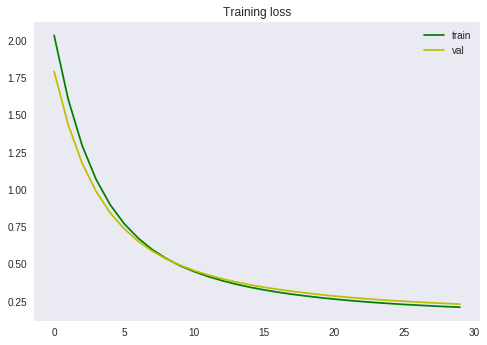

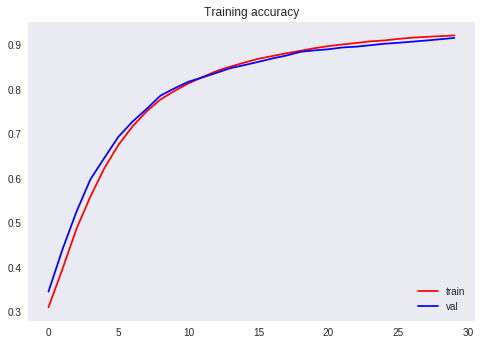

In [50]:
plot_loss_accu(h)

In [51]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2235651614931135
Test accuracy: 0.9205370101596516


In [52]:
!ls

kaggle.json  sample_data  x_test.npy   x_val.npy   y_train.npy
malaria.zip  vgg.h5	  x_train.npy  y_test.npy  y_val.npy


In [53]:
from google.colab import files
files.download("vgg.h5")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 38728, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

| Experiments | Train | Val  | Test | Others 
|------|------|------|------|------|
|   Softmax layer train | 93.52 | 93.61 |  93.06 | VGG all layer frozen
|   Softmax layer train | 93.52 | 93.61 |  **93.46** | Test Time Augmentation
|   All layer train   | 96.28| 95.61   | 94.77  | VGG16
|   VGG   | xx | xx  | xx  | VGG16
|   VGG   | xx | xx  | xx  | VGG16
|   VGG   | xx| xx   | xx  | VGG16
|   VGG   | xx | xx  | xx  | VGG16
|   VGG   | xx| xx   | xx  | VGG16

# Using model.predict(test)

In [0]:
y_pred = model.predict(x_test)
y_pred.shape

(2756, 2)

In [0]:
# get labels from predictions
pred_labels = np.array([np.argmax(pred) for pred in y_pred])
pred_labels.shape

0

In [0]:
#convert ground truths to column values
y_test = np.argmax(y_test, axis=1)
y_test.shape

(2756,)

In [0]:
# check shape for ground truth and predicted labels
y_test.shape, pred_labels.shape

((2756,), (2756,))

In [0]:
x = 93.2504
y = 93.4687

y-x

0.21829999999999927

In [0]:
print('Accuracy: ',np.mean((y_test==pred_labels)))

Accuracy:  0.9306966618287373


## Test of time

In [0]:
label_pred = test_of_time(x_test)
labels.shape


# for tta
labels= np.array([np.argmax(pred) for pred in label_pred])
labels.shape


In [0]:

#convert ground truths to column values
y_test = np.argmax(y_test, axis=1)
y_test.shape



# check shape for ground truth and predicted labels: (N,)
y_test.shape, labels.shape

In [0]:

print('Accuracy with TTA: ',np.mean((y_test==labels)))

